**Projeto integrador**

Parte do Modulo Inferencia, da Pos Graduação em Data Science e Big Data da UFPR. Utilizar o modelo logistico para prever o numero de inscritos acumulados em canais do Youtube.

---

Codigo desenvolvido por Lucas Vinicio Maldonado.

In [33]:
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.optimize as optim 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
#Substituir caminho correspondete do arquivo youtube.txt
data = pd.read_csv(r'/content/youtube.txt', sep=" ", header=0)
data['INSCRITOS'] = data['INSCRITOS']/100000
data.describe()

,DIAS,VIEWS,INSCRITOS
count,1457.000000,1457.000000,1457.000000
mean,374.881949,134515.582704,0.025028
std,227.023743,148105.799943,0.020542
min,1.000000,89.000000,0.000010
25%,183.000000,25700.000000,0.006570
50%,365.000000,98024.000000,0.020510
75%,547.000000,172000.000000,0.038870
max,850.000000,934121.000000,0.146110


In [21]:
#Dados separados de cada canal
df_ch1 = data.iloc[:850,:]
df_ch1['y'] = data.loc[:850,'INSCRITOS'].cumsum()

df_ch2 = data.iloc[850:,:]
df_ch2['y'] = data.loc[850:,'INSCRITOS'].cumsum()
print(len(df_ch2['y']))


607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Analise do canal Invento na Hora

In [23]:
##Analise do canal Invento na Hora

#Modelagem logisticia
def ModLogist(x,a,b,c):
    fnc = a/(1+np.exp(-b*(x-c)))
    #Função para a perda
    #Eq_Perda = sum((y -fnc)^2)
    return fnc

def residual(p, x, y):
    return y - ModLogist(x, *p)

#Otimização da função
## Foram testados 3 modelos, cada um com formas diferentes de passar os argumentos e metodos de otimização diferentes
## Todos geraram resultados similares. Escolhi finalmente usar o leastsq.

#Foram testados manualmente diversos valores para x0 - L, beta,beta1 - ate encontrar os que mais aproximam a função
x0 = np.array([30, 1, 700])
#bounds=((30,0,500), (40, 1, 700))
#optimized = minimize(fun=ModLogist, args=(df_ch1['y']), x0 = x0, method='BFGS')
#(a,b,c), pcov = optim.curve_fit(ModLogist,xdata= df_ch1['DIAS'], ydata=df_ch1['y'], p0=x0 )
x= df_ch1['DIAS']
y=df_ch1['y']
popt, pcov = optim.leastsq(residual, x0, args=(x, y))
a,b,c = popt[:]

In [25]:
##Estimando os valores de y para o proximo ano e juntando com os registrados para visualização
y_estimado = []
for x in range(850,1215):
    y_estimado.append(a/(1+np.exp(-b*(x-c))))
y_1 = df_ch1['y'].tolist()
y_1.extend(y_estimado)

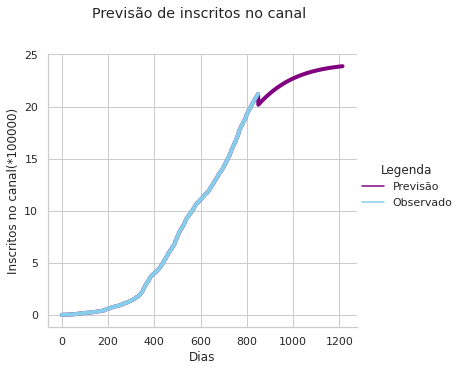

In [120]:
sns.set_theme(style="whitegrid")

df1 = pd.DataFrame({'Dias': list(range(0,1215)), 'Inscritos no canal(*100000)': y_1, 'Legenda': 'Previsão'})
df2 = pd.DataFrame({'Dias': list(range(0,850)), 'y2': df_ch1['y'], 'Legenda': 'Observado'}).rename(columns={'y2': 'Inscritos no canal(*100000)'})

df = pd.concat([df1, df2]).reset_index(drop=True)


g = sns.relplot(data=df, x = 'Dias', y = 'Inscritos no canal(*100000)', kind = 'line', hue = 'Legenda', palette = ['Purple', 'skyblue'],linewidth=4  )
g.fig.suptitle("Previsão de inscritos no canal", x=0.43, y=0.98)
plt.subplots_adjust(top=0.85)


In [144]:
#Total de inscritos apos um ano

y_365 = y_1[-1:].pop()
print(y_365*100000)

2387158.39431165


# Analise do canal Voce Sabia

In [51]:
#Novamente, diversos valores manuais foram testados ate obter os que convergiam.
x02 = np.array([45, 0.06, 700])
x2= df_ch2['DIAS']
y2=df_ch2['y']

popt2, pcov2 = optim.leastsq(residual, x02, args=(x2, y2))

a2,b2,c2 = popt2[:]
print(a2,b2,c2)

48.978393790700956 0.007071967488260629 713.0784062772449


In [53]:
y_estimado2 = []
#resultados de y para 850 +365 dias 
for x in range(607,972):
    y_estimado2.append(a2/(1+np.exp(-b2*(x-c2))))

y_2 = df_ch2['y'].tolist()
y_2.extend(y_estimado2)

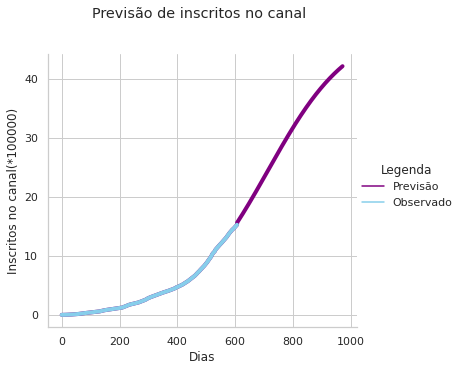

In [124]:
sns.set_theme(style="whitegrid")

df1 = pd.DataFrame({'Dias': list(range(0,972)), 'Inscritos no canal(*100000)': y_2, 'Legenda': 'Previsão'})
df2 = pd.DataFrame({'Dias': list(range(0,607)), 'y2': df_ch2['y'], 'Legenda': 'Observado'}).rename(columns={'y2': 'Inscritos no canal(*100000)'})

df = pd.concat([df1, df2]).reset_index(drop=True)


g = sns.relplot(data=df, x = 'Dias', y = 'Inscritos no canal(*100000)', kind = 'line', hue = 'Legenda', palette = ['Purple', 'skyblue'],  linewidth=4 )

g.fig.suptitle("Previsão de inscritos no canal", x=0.43, y=0.98)
plt.subplots_adjust(top=0.85)

In [143]:
#Total de inscritos apos um ano

y_365 = y_2[-1:].pop()
print(y_365*100000)

4217269.775587481


#Conclusões e referencias

Ainda que a otimização não tenha se adaptado totalmente aos dados observados, é possivel obter uma previsão com elevada acuracia. Isso se deve principalmente a natureza do problema, visto que o numero de inscritos de um canal se comporta de tal forma aproximadamente.


---



De acordo com as estimativas, o numero de inscritos no canal Invento na hora sera de **2387158**, aproximadamente.


Ja para o canal Voce Sabia, apos um ano o numero de inscritos sera de **4217269**, aproximadamente. 



https://mmas.github.io/least-squares-fitting-numpy-scipy
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize